In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

## Import CPI data

The data comes from destatis: https://www-genesis.destatis.de/genesis/online?sequenz=statistikTabellen&selectionname=61111


In [86]:
cols = ["year","month","CPI", "annual_change", "monthly_change"]
m_inf = pd.read_csv(
    'data/61111-0002_$F.csv', encoding="ISO-8859-3", 
    skiprows=6, sep=';', header=None,names=cols, decimal=',',
    skipfooter=3
)
# Create a date columns
m_inf['m'] = m_inf.index % 12 + 1
m_inf['date'] = pd.to_datetime(m_inf.year.astype(str) + '/' + m_inf.m.astype(str) + '/01')

# Define starting point
m_inf = m_inf[m_inf['date']>=pd.to_datetime(date(2003,1,1))].reset_index(drop=True)

# Replace ... with None and parse CPI as float
m_inf = m_inf.replace('...',None)
m_inf['CPI'] = m_inf['CPI'].astype(float)

# Parse monthly change
m_inf['monthly_change'] = m_inf['monthly_change'].replace('-',0).astype(float)

# Rebase inflation from starting point
now = pd.to_datetime(date(2023,9,1))
base = m_inf.loc[m_inf['date']==now,'CPI'].values[0]

m_inf['CPI_base'] = m_inf['CPI'] / base

m_inf



/tmp/ipykernel_157536/2142038585.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  m_inf = pd.read_csv(


,year,month,CPI,annual_change,monthly_change,m,date,CPI_base
0,2003,Januar,78.5,1.0,0.0,1,2003-01-01,0.666384
1,2003,Februar,79.0,1.3,0.6,2,2003-02-01,0.670628
2,2003,März,79.0,1.0,0.0,3,2003-03-01,0.670628
3,2003,April,78.8,0.9,-0.3,4,2003-04-01,0.668930
4,2003,Mai,78.6,0.5,-0.3,5,2003-05-01,0.667233
...,...,...,...,...,...,...,...,...
247,2023,August,117.5,6.1,0.3,8,2023-08-01,0.997453
248,2023,September,117.8,4.5,0.3,9,2023-09-01,1.000000
249,2023,Oktober,117.8,3.8,0.0,10,2023-10-01,1.000000
250,2023,November,NaN,None,NaN,11,2023-11-01,NaN


# Create table of TV Stud pay

In [90]:
from datetime import date
tvst = [
    {"date": date(2003,1,1), 'tv_stud': 10.98},
    {"date": date(2018,6,1), 'tv_stud': 12.30},
    {"date": date(2019,1,1), 'tv_stud': 12.50},
    {"date": date(2021,1,1), 'tv_stud': 12.68},
    {"date": date(2022,1,1), 'tv_stud': 12.96},
    {"date": date(2023,11,1), 'tv_stud': 12.96*1.1},
]
tvsdf = pd.DataFrame.from_dict(tvst)
tvsdf['date'] = pd.to_datetime(tvsdf['date'])
tvsdf

,date,tv_stud
0,2003-01-01,10.980
1,2018-06-01,12.300
2,2019-01-01,12.500
3,2021-01-01,12.680
4,2022-01-01,12.960
5,2023-11-01,14.256


# Create table of minimum wage

In [91]:
mdl = [
    {"date": date(2015,1,1), 'mdl': 8.50}, #https://www.destatis.de/DE/Themen/Arbeit/Verdienste/Mindestloehne/Tabellen/gesetzlicher-mindestlohn.html
    {"date": date(2017,3,1), 'mdl': 8.84}, 
    {"date": date(2019,1,1), 'mdl': 9.19},
    {"date": date(2020,9,1), 'mdl': 9.35},
    {"date": date(2021,1,1), 'mdl': 9.50},
    {"date": date(2021,7,1), 'mdl': 9.60},
    {"date": date(2022,1,1), 'mdl': 9.82},
    {"date": date(2022,7,1), 'mdl': 10.45},
    {"date": date(2022,10,1), 'mdl': 12},
]
mdldf = pd.DataFrame.from_dict(mdl)
mdldf['date'] = pd.to_datetime(mdldf['date'])
mdldf

,date,mdl
0,2015-01-01,8.50
1,2017-03-01,8.84
2,2019-01-01,9.19
3,2020-09-01,9.35
4,2021-01-01,9.50
5,2021-07-01,9.60
6,2022-01-01,9.82
7,2022-07-01,10.45
8,2022-10-01,12.00


## Merge and plot both series divided by CPI

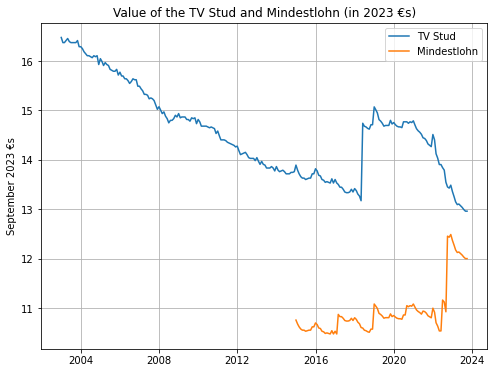

In [92]:
comp = m_inf.merge(tvsdf, how='outer').merge(mdldf,how='outer')
comp['tv_stud'] = comp['tv_stud'].fillna(method='ffill')
comp['tv_stud_real'] = comp['tv_stud'] / comp['CPI_base'] 
comp['mdl'] = comp['mdl'].fillna(method='ffill')
comp['mdl_real'] = comp['mdl'] / comp['CPI_base'] 
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(
    comp['date'],
    comp['tv_stud_real'],
    label='TV Stud'
)
ax.plot(
    comp['date'],
    comp['mdl_real'],
    label='Mindestlohn'
)
ax.legend()
ax.set_ylabel('September 2023 €s')
ax.set_title('Value of the TV Stud and Mindestlohn (in 2023 €s)')
ax.grid()
plt.savefig('plots/TV-stud.png')

,year,month,CPI,annual_change,monthly_change,m,date,CPI_base,tv_stud,mdl,tv_stud_real,mdl_real,mdl_ratio
0,2003,Januar,78.5,1.0,0.0,1,2003-01-01,0.666384,10.980,NaN,16.476994,NaN,NaN
1,2003,Februar,79.0,1.3,0.6,2,2003-02-01,0.670628,10.980,NaN,16.372709,NaN,NaN
2,2003,März,79.0,1.0,0.0,3,2003-03-01,0.670628,10.980,NaN,16.372709,NaN,NaN
3,2003,April,78.8,0.9,-0.3,4,2003-04-01,0.668930,10.980,NaN,16.414264,NaN,NaN
4,2003,Mai,78.6,0.5,-0.3,5,2003-05-01,0.667233,10.980,NaN,16.456031,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2023,August,117.5,6.1,0.3,8,2023-08-01,0.997453,12.960,12.0,12.993089,12.030638,1.08
248,2023,September,117.8,4.5,0.3,9,2023-09-01,1.000000,12.960,12.0,12.960000,12.000000,1.08
249,2023,Oktober,117.8,3.8,0.0,10,2023-10-01,1.000000,12.960,12.0,12.960000,12.000000,1.08
250,2023,November,NaN,None,NaN,11,2023-11-01,NaN,14.256,12.0,NaN,NaN,NaN


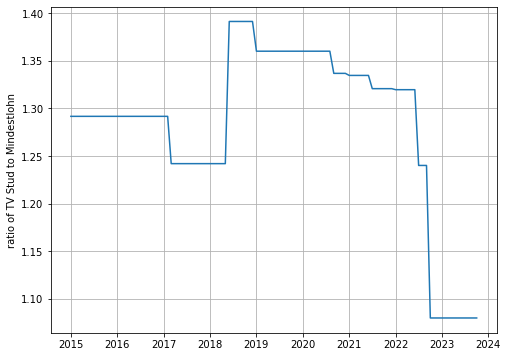

In [93]:
comp['mdl_ratio'] = comp['tv_stud_real'] / comp['mdl_real']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(
    comp['date'],
    comp['mdl_ratio']
)
ax.set_ylabel('ratio of TV Stud to Mindestlohn')
ax.grid()
comp

## Create a dataframe of TVL pay

In [97]:
from datetime import date
tvod = [
    {"date": date(2010,3,1), 'tv13': 3064},
    {"date": date(2011,4,1), 'tv13': 3110},
    {"date": date(2012,1,1), 'tv13': 3186},
    {"date": date(2013,1,1), 'tv13': 3271},
    {"date": date(2014,1,1), 'tv13': 3367},
    {"date": date(2015,3,1), 'tv13': 3438},
    {"date": date(2016,3,1), 'tv13': 3517},
    {"date": date(2017,1,1), 'tv13': 3587},
    {"date": date(2018,1,1), 'tv13': 3672},
    {"date": date(2019,1,1), 'tv13': 3837},
    {"date": date(2020,1,1), 'tv13': 4002},
    {"date": date(2021,1,1), 'tv13': 4074},
    {"date": date(2023,4,1), 'tv13': 4188},
    {"date": date(2023,11,1), 'tv13': 4188 +max(4188*.10,500)},    
]
tvdf = pd.DataFrame.from_dict(tvod)
tvdf['date'] = pd.to_datetime(tvdf['date'])
tvdf

,date,tv13
0,2010-03-01,3064
1,2011-04-01,3110
2,2012-01-01,3186
3,2013-01-01,3271
4,2014-01-01,3367
5,2015-03-01,3438
6,2016-03-01,3517
7,2017-01-01,3587
8,2018-01-01,3672
9,2019-01-01,3837


## Merge and reindex to first available data point

In [100]:

comp = m_inf.merge(tvsdf, how='outer').merge(mdldf,how='outer').merge(tvdf, how='outer')
def reindex(comp, var):
    comp[var] = comp[var].fillna(method='ffill')
    vbase, cbase = comp.loc[pd.notna(comp[var]),[var,'CPI']].values[0]
    comp[f'{var}_real'] = (comp[var] / vbase) / (comp['CPI'] / cbase )
    return comp

comp['CPI'] = comp['CPI'].fillna(method='ffill')
    
comp = reindex(comp, 'tv_stud')
comp = reindex(comp, 'tv13')
comp

,year,month,CPI,annual_change,monthly_change,m,date,CPI_base,tv_stud,mdl,tv13,tv_stud_real,tv13_real
0,2003,Januar,78.5,1.0,0.0,1,2003-01-01,0.666384,10.980,NaN,NaN,1.000000,NaN
1,2003,Februar,79.0,1.3,0.6,2,2003-02-01,0.670628,10.980,NaN,NaN,0.993671,NaN
2,2003,März,79.0,1.0,0.0,3,2003-03-01,0.670628,10.980,NaN,NaN,0.993671,NaN
3,2003,April,78.8,0.9,-0.3,4,2003-04-01,0.668930,10.980,NaN,NaN,0.996193,NaN
4,2003,Mai,78.6,0.5,-0.3,5,2003-05-01,0.667233,10.980,NaN,NaN,0.998728,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2023,August,117.5,6.1,0.3,8,2023-08-01,0.997453,12.960,NaN,4188.0,0.788559,1.024840
248,2023,September,117.8,4.5,0.3,9,2023-09-01,1.000000,12.960,NaN,4188.0,0.786551,1.022230
249,2023,Oktober,117.8,3.8,0.0,10,2023-10-01,1.000000,12.960,NaN,4188.0,0.786551,1.022230
250,2023,November,117.8,None,NaN,11,2023-11-01,NaN,14.256,NaN,4688.0,0.865206,1.144272


## Plot TV-L 13 and TV-Stud, including the planned rises as demanded by the unions

For illustration purposes, rises are implemented in November 2023, and CPI stays at the same level as October 2023

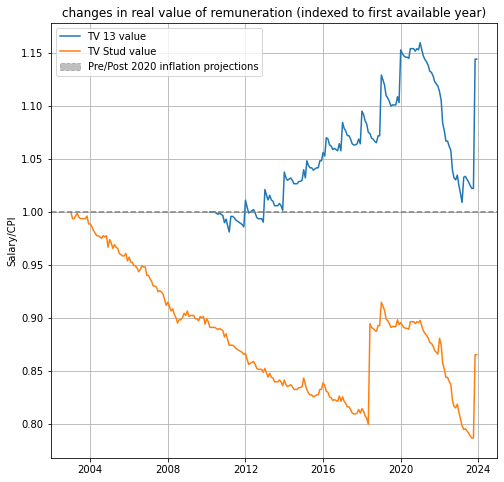

In [105]:
series = ['tv13_real','tv_stud_real']
labels = ['TV 13','TV Stud']

fig, ax = plt.subplots(figsize=(8,8))

for i,(s, l) in enumerate(zip(series, labels)):
    ax.plot(comp['date'],comp[s], label=f'{l} value', color=f'C{i}')
    
ax.fill_between([],[],[],color='grey', alpha=0.5, ls='--', label='Pre/Post 2020 inflation projections')

ax.axhline(1, ls='--', color='grey')

ax.legend(loc='upper left')
ax.set_ylabel('Salary/CPI')

ax.set_title('changes in real value of remuneration (indexed to first available year)')

ax.grid()